In [1]:
import torch
from model import HierarchicalCore
# Define example hyperparameters.
latent_dims = [4, 4, 4]  # For example, 3 latent scales with 4 channels each.
channels_per_block = [24, 48, 96, 192]  # Four encoder levels.
# Optionally, you can set down_channels_per_block to the same as channels_per_block.
down_channels_per_block = None  

# Instantiate the prior network using HierarchicalCore.
# For the prior, the input is typically the image only.
prior_net = HierarchicalCore(
    latent_dims=latent_dims,
    channels_per_block=channels_per_block,
    down_channels_per_block=down_channels_per_block,
    activation_fn=torch.nn.functional.relu,
    convs_per_block=3,
    blocks_per_level=3
)

# Create a dummy input image tensor.
# PyTorch uses (B, C, H, W). Here, assume a grayscale image (1 channel) of size 128x128, batch size 2.
dummy_input = torch.randn(2, 1, 128, 128)

# Run the prior network.
# The 'mean' flag indicates whether to use the distribution's mean (deterministic) or to sample.
output = prior_net(dummy_input, mean=False)

# Access and print the outputs.
decoder_features = output['decoder_features']
encoder_outputs = output['encoder_features']
distributions = output['distributions']
used_latents = output['used_latents']

print("Decoder features shape:", decoder_features.shape)
print("Number of encoder outputs:", len(encoder_outputs))
print("Latent distributions:", distributions)
print("Used latent shapes:", [z.shape for z in used_latents])

Decoder features shape: torch.Size([2, 24, 128, 128])
Number of encoder outputs: 4
Latent distributions: [Independent(Normal(loc: torch.Size([2, 4, 16, 16]), scale: torch.Size([2, 4, 16, 16])), 1), Independent(Normal(loc: torch.Size([2, 4, 32, 32]), scale: torch.Size([2, 4, 32, 32])), 1), Independent(Normal(loc: torch.Size([2, 4, 64, 64]), scale: torch.Size([2, 4, 64, 64])), 1)]
Used latent shapes: [torch.Size([2, 4, 16, 16]), torch.Size([2, 4, 32, 32]), torch.Size([2, 4, 64, 64])]


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from model import HierarchicalProbUNet


# --- Dummy Dataset ---
class DummyLIDCDataset(Dataset):
    """
    A dummy dataset simulating LIDC 2D crops.
    Each sample returns:
      - a single-channel image tensor of shape (1, H, W)
      - a segmentation target of shape (H, W) with integer labels (0 or 1)
    """
    def __init__(self, num_samples=100, image_size=128):
        super().__init__()
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Simulate a CT scan crop (normalized random noise)
        image = torch.randn(1, self.image_size, self.image_size)
        # Simulate segmentation target with 2 classes (background=0, lesion=1)
        seg = torch.randint(0, 2, (self.image_size, self.image_size), dtype=torch.long)
        return image, seg

# --- Create DataLoader ---
dataset = DummyLIDCDataset(num_samples=20, image_size=128)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# --- Instantiate the HierarchicalProbUNet ---
# Here we use the default latent_dims and channel configurations inspired by the paper.
# (Note: The PyTorch conversion uses default values if channels_per_block and down_channels_per_block are None.)
model = HierarchicalProbUNet(
    latent_dims=(1, 1, 1, 1),
    channels_per_block=None,        # Will use default: (24, 48, 96, 192, 192, 192, 192, 192)
    num_classes=2,
    down_channels_per_block=None,   # Defaults to channels_per_block // 2
    activation_fn=torch.nn.functional.relu,
    convs_per_block=3,
    blocks_per_level=3,
    loss_kwargs=None                # Defaults to GECO with parameters from the paper
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Test Loop: Forward Pass & Loss Computation ---
model.train()  # Set to training mode if needed

for batch_idx, (img, seg) in enumerate(dataloader):
    # Move data to device
    img = img.to(device)  # Shape: (B, 1, 128, 128)
    seg = seg.to(device)  # Shape: (B, 128, 128); class indices in {0,1}

    # Test the sample() method (prior branch) to generate segmentation logits.
    seg_sample = model.sample(img, mean=False)
    print(f"Batch {batch_idx} sample shape: {seg_sample.shape}")
    # Expected output shape: (B, num_classes, H, W), i.e. (2, 2, 128, 128)

    # Compute the reconstruction loss (and KL divergence) using the loss() method.
    print(f'seg shape: {seg.shape}')
    print(f'img shape: {img.shape}')
    loss_dict = model.loss(seg, img, mask=None)
    loss_val = loss_dict['supervised_loss']
    print(f"Batch {batch_idx} supervised loss: {loss_val.item():.4f}")
    print("Loss summaries:", loss_dict['summaries'])

    # Optionally, perform a backward pass and optimizer step.
    # optimizer.zero_grad()
    # loss_val.backward()
    # optimizer.step()

    # For demonstration, break after one batch.
    break

print("Model forward and loss computation test completed successfully.")


Batch 0 sample shape: torch.Size([2, 2, 128, 128])
seg shape: torch.Size([2, 128, 128])
img shape: torch.Size([2, 1, 128, 128])
Batch 0 supervised loss: 4.0310
Loss summaries: {'rec_loss': 0.6973758935928345, 'kl_sum': 3.3836042881011963, 'kl_0': 0.19572210311889648, 'kl_1': 1.757439374923706, 'kl_2': 0.22868603467941284, 'kl_3': 1.2017567157745361, 'geco_loss': 4.030980110168457, 'ma_rec_loss': 0.6973758935928345, 'lagmul': 1.0}
Model forward and loss computation test completed successfully.


In [3]:
# Assume your dataset and transform are defined as in your provided code.
from dataset_ACDC import ACDCdataset, RandomGenerator

# Set the desired output size (e.g., 128x128)
output_size = (128, 128)
transform = RandomGenerator(output_size)
dataset = ACDCdataset(base_dir="datasets/ACDC", list_dir="datasets/ACDC/lists_ACDC", split="train", transform=transform)

sample = dataset[0]
print("Image shape:", sample['image'].shape)   # Expected: (1, 128, 128)
print("Label shape:", sample['label'].shape)     # Expected: (128, 128)


Image shape: torch.Size([1, 128, 128])
Label shape: torch.Size([128, 128])


In [5]:
import numpy as np
# Display the unique values in the label and their counts
unique_values = np.unique(sample['label'])
print("Unique values in label:", unique_values)

Unique values in label: [0]


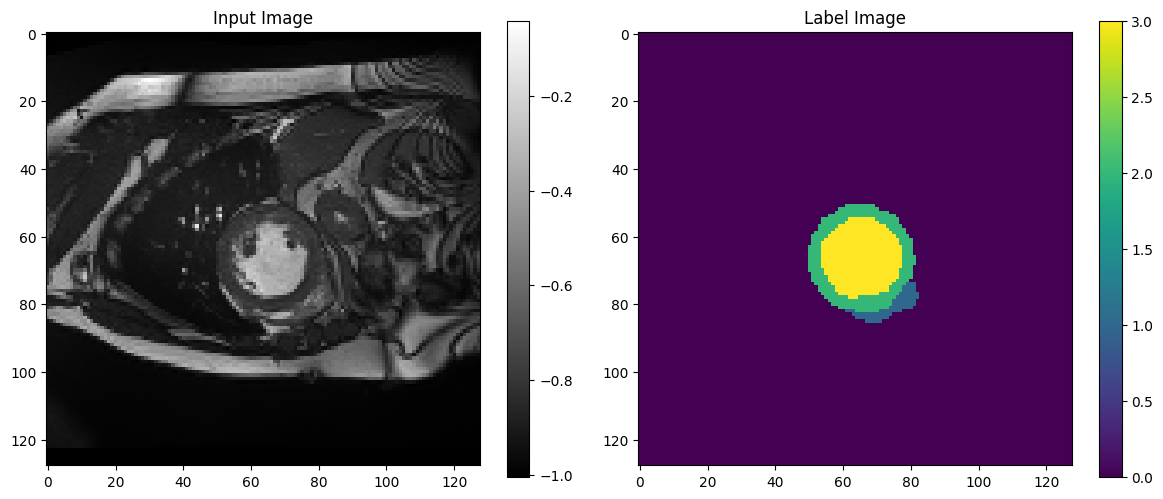

Unique label values: [0 1 2 3]


In [7]:
# Display input image and label image
import matplotlib.pyplot as plt

# Get a sample from the dataset
sample = dataset[15]

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Display the input image (squeeze removes singleton dimensions)
plt.subplot(1, 2, 1)
plt.imshow(sample['image'].squeeze(), cmap='gray')
plt.title('Input Image')
plt.colorbar()
plt.axis('on')

# Display the label image
plt.subplot(1, 2, 2)
plt.imshow(sample['label'], cmap='viridis')  # 'viridis' is good for categorical data
plt.title('Label Image')
plt.colorbar()
plt.axis('on')

plt.tight_layout()
plt.show()

# Print unique label values for reference
import numpy as np
unique_values = np.unique(sample['label'])
print("Unique label values:", unique_values)